In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots
import colorcet as cc
from MCEq.core import MCEqRun
from MCEq.config import config
import crflux.models as pm

In [2]:
#Initialize the model type for MCEq
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='SIBYLL2.3c',
    #primary cosmic ray flux model
    #support a tuple (primary model class (not instance!), arguments)
    primary_model=(pm.HillasGaisser2012, 'H3a'),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
    )

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [ ]:
def simulate(min_angle, max_angle, num_bins): 
    global result_total, result_pr, result_conv, result_pi, result_D, result_D0, result_Ds, result_k, result_K_L0, result_K_S0, result_mudecay, e_center

    # Convert angle bounds to zenith angles
    max_zenith = np.cos(np.deg2rad(float(max_angle)))
    min_zenith = np.cos(np.deg2rad(float(min_angle)))
    angles_edges = np.arccos(np.linspace(min_zenith, max_zenith, num_bins)) * 180. / np.pi
    angles = np.zeros(num_bins - 1)
    for i in range(len(angles)):
        angles[i] = np.mean([angles_edges[i], angles_edges[i+1]])    
    angles = np.round(angles, decimals=2)    

    mceq_run.set_density_model(('MSIS00_IC', ('SouthPole', 'January')))    

    # Set up variables
    mag = 3  # Energy scaling
    d = 0    # Day of year: Jan 1
    result_total = []
    result_pr = []
    result_conv = []
    result_pi = []
    result_mudecay = []    

    # Loop through angles and calculate results
    for sim_angle in angles:
        print('zenith:', sim_angle)
        mceq_run.set_theta_deg(sim_angle)
        result_total.append([])
        result_conv.append([])
        result_pr.append([])
        result_pi.append([])
        result_mudecay.append([])        

        mceq_run.density_model.set_doy(d)
        mceq_run.density_model.theta_deg = np.deg2rad(sim_angle)
        mceq_run.density_model.calculate_density_spline()
        mceq_run._calculate_integration_path(int_grid=None, grid_var='X', force=True)
        mceq_run.solve()

        result_total[-1].append(
            mceq_run.get_solution('total_numu', mag) +
            mceq_run.get_solution('total_antinumu', mag)
        )
        result_pr[-1].append(
            mceq_run.get_solution('pr_numu', mag) +
            mceq_run.get_solution('pr_antinumu', mag)
        )
        result_conv[-1].append(
            mceq_run.get_solution('conv_numu', mag) +
            mceq_run.get_solution('conv_antinumu', mag)
        )
        result_pi[-1].append(
            mceq_run.get_solution('pi_numu', mag) +
            mceq_run.get_solution('pi_antinumu', mag)
        )
        result_mudecay[-1].append(
            mceq_run.get_solution('mulr_numu', mag) +
            mceq_run.get_solution('mulr_antinumu', mag) +
            mceq_run.get_solution('mu_h0_antinumu', mag) +
            mceq_run.get_solution('mu_h0_numu', mag)
        )

    # Set global energy bin centers
    e_center = (mceq_run.e_bins[:-1] + mceq_run.e_bins[1:]) / 2

In [7]:
p = mceq_run.pman
print("D0 children:", [c.name for c in p[(421, 0)].children])

D0 children: ['K-', 'pi-', 'mu+', 'e+', 'e-', 'nue', 'mu-', 'numu', 'gamma', 'pi0', 'K_L0', 'pi+', 'K_S0', 'K+', 'prcas_nue', 'prcas_mu+', 'prcas_mu-', 'prcas_numu']


In [12]:
simulate(0,180,12)

MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
zenith: 17.55
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 17.55
zenith: 42.79
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 42.79
zenith: 56.72
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 56.72
zenith: 68.57
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 68.57
zenith: 79.48
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 79.48
zenith: 90.0
MSIS00IceCubeCentered::set_theta(): latitude = -89.86 for zenith angle = 90.00
zenith: 100.52
MSIS00IceCubeCentered::set_theta(): latitude = -68.96 for zenith angle = 100.52
MSIS00IceCubeCentered::set_theta(): theta = 100.52 below horizon. using theta = 79.48
zenith: 111.43
MSIS00IceCubeCentered::set_theta(): latitude = -47.14 for zenith angle = 111

In [9]:
def plotter():
    A4_width_inches = 0.25*8.27  # Width of A4 paper in inches
    A4_height_inches = A4_width_inches * 0.75
    figsize = (A4_width_inches, A4_height_inches)

    # Font scaling
    base_width = 8.27
    scale = 2* A4_width_inches / base_width
    base_fontsize = 10
    #I had to add this since rescaling the plot did not rescale the hardcoded text size
    plt.rcParams.update({'font.size': base_fontsize * scale})
    A4_height_inches = A4_width_inches * 0.75 # Height is one-third of width
    figsize = (A4_width_inches, A4_height_inches)    
    
    # Create subplots using GridSpec
    fig = plt.figure(figsize=figsize, dpi=500)
    fig.tight_layout(pad=0.4)
    plt.style.use('science')
    plt.style.use('tableau-colorblind10')
    plt.rcParams['text.usetex'] = False
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']    
    
    # Create a gridspec with 2 rows and 1 column, where the second row will be narrow
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=.1)  # 3:1 ratio between upper and lower plots    
    
    # Upper plot for the spectrum
    ax1 = fig.add_subplot(gs[0])
    # Lower plot for the fraction
    ax2 = fig.add_subplot(gs[1], sharex=ax1)    
    
    # Plot lines with labels (same as before)
    #Example text for numu + antinumu from (source): r'$\nu_{\mathrm{\mu}} + \bar{\nu}_{\mathrm{\mu}}$ (total)'
    line_total, = ax1.plot(e_center, np.mean(result_total, axis=0)[0], color='black', label="Total")  
    line_pi, = ax1.plot(e_center, np.mean(result_pi, axis=0)[0], label=r'$\pi$', color=colors[5])
    line_pr, = ax1.plot(e_center, np.mean(result_pr, axis=0)[0], label='Prompt', color="lightgrey")
    line_conv, = ax1.plot(e_center, np.mean(result_conv, axis=0)[0], label='Conventional', color="grey")
    line_mudecay, = ax1.plot(e_center, np.mean(result_mudecay, axis=0)[0], label=r'$\mu$ decay', color="magenta")
    
    # Axes labels and text (same as before)
    #ax1.set_xlabel('$E$/GeV')
    ax1.set_ylabel(r'$E^{3}$ $\Phi_{\nu_\mu + \bar{\nu}_\mu}$ /' + '\n' + r'GeV$^{2}$ cm$^{-2}$s$^{-1}$sr$^{-1}$')
    ax1.text(0.35, 0.05, '$0^{\circ} \leq \Theta \leq 180^{\circ}$', verticalalignment='bottom', horizontalalignment='right', transform=ax1.transAxes, color=colors[3])
    plt.setp(ax1.get_xticklabels(), visible=False)    
    
    # Log scales and limits (same as before)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(50., 1e9)
    ax1.set_ylim(2e-6, 1.1e-1)
    ax1.minorticks_on()
    ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
    ax1.tick_params(axis='y', which='both', direction='in', left=True, right=True)    
    
    # Dummy lines for January to show in legend in color[3]
    line_jan = plt.Line2D([0], [0], color=colors[3],  label='January ')
    
    # Legend for line styles (solid and dashed), placed inside the plot
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.15), ncol=2)    
    # Plot fraction of each parent to the total flux in the lower plot
    fraction_pi = np.mean(result_pi, axis=0) / np.mean(result_total, axis=0)
    fraction_pr = np.mean(result_pr, axis=0) / np.mean(result_total, axis=0)
    fraction_conv = np.mean(result_conv, axis=0) / np.mean(result_total, axis=0)
    fraction_mudecay = np.mean(result_mudecay, axis=0) / np.mean(result_total, axis=0)   

    #Plot the data 
    ax2.plot(e_center, fraction_pi[0], label=r'Fraction from $\pi$', color=colors[5])
    ax2.plot(e_center, fraction_pr[0], label=r'Fraction from $\mu$ (prompt)', color="lightgrey")
    ax2.plot(e_center, fraction_conv[0], label=r'Fraction from $\mu$ (conventional)', color="grey")
    ax2.plot(e_center, fraction_mudecay[0], label=r'Fraction from $\mu$ decay', color="magenta")
    ax2.set_xlabel('$E$/GeV')
    ax2.set_ylabel('Fraction ')    
    # Set limits for the lower plot
    ax2.set_xscale('log')
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_xlim(50., 1e9)    
    # Save the figure
    #plt.savefig(save_folder, bbox_inches='tight')
    plt.show()

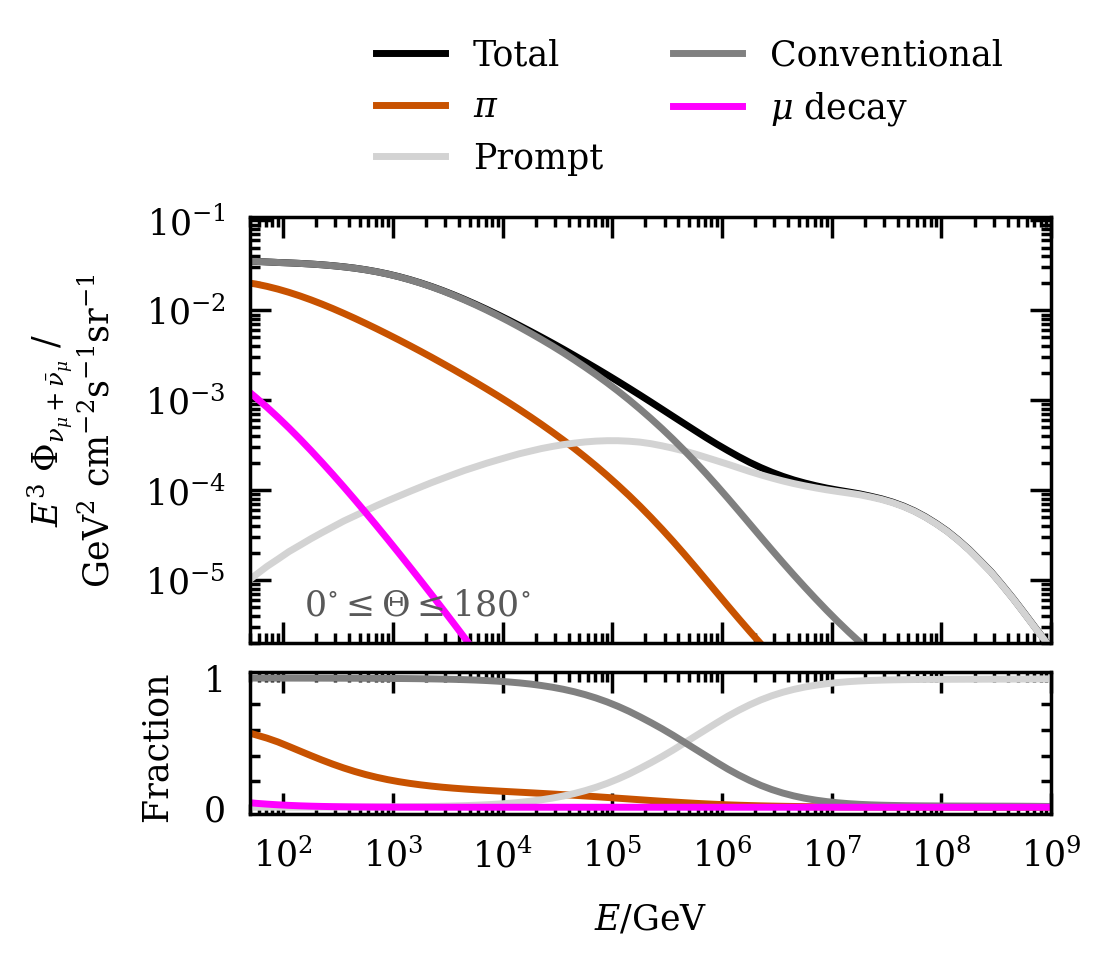

In [10]:
plotter()

In [35]:


mceq_run.pman.print_particle_tables(0)



Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"pi0", "K_L0", "pi-", "pi+", "K_S0", 
"K-", "K+", "D-", "D+", "Dbar0", 
"D0", "D_s-", "D_s+", "nbar0", "n0", 
"Lambdabar0", "Lambda0"

Resonances:


Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:
"pi_antinue", "pi_nue", "pi_mu+_l", "pi_mu+_r", "pi_mu-_l", 
"pi_mu-_r", "pi_antinumu", "pi_numu", "k_antinue", "k_nue", 
"k_mu+_l", "k_mu+_r", "k_mu-_l", "k_mu-_r", "k_antinumu", 
"k_numu", "mulr_antinue", "mulr_nue", "mulr_antinumu", "mulr_numu", 
"mu_h0_antinue", "mu_h0_nue", "mu_h0_antinumu", "mu_h0_numu", "mu_antinue", 
"mu_nue", "mu_antinumu", "mu_numu", "K0_antinue", "K0_nue", 
"K0_mu+", "K0_mu-", "K0_antinumu", "K0_numu", "prcas_antinue", 
"prcas_nue", "prcas_mu+", "prcas_mu-", "prcas_antinumu", "prcas_numu", 
"prcas_antinutau", "prcas_nutau", "prres_antinue", "prres_nue", "prres_mu+", 
"prres_mu-", "prres_antinumu", "prres_numu"

